# intent classification pipeline

Based on CLINC150 dataset: 150 intent classes including an out of scope class (OOS).


In [177]:
import numpy as np
import transformers as tfm
from transformers import pipeline
import torch
from src.n08 import distillation, perf_benchmark



The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [137]:
# starting model: BERT finetuned on the CLINC150 dataset

BERT_CKPT = "transformersbook/bert-base-uncased-finetuned-clinc"
pipe = pipeline("text-classification", model=BERT_CKPT)

In [3]:
from datasets import load_dataset
clinc = load_dataset("clinc_oos", "plus")

intents = clinc["test"].features["intent"]

Reusing dataset clinc_oos (/Users/SPayot/.cache/huggingface/datasets/clinc_oos/plus/1.0.0/abcc41d382f8137f039adc747af44714941e8196e845dfbdd8ae7a7e020e6ba1)


  0%|          | 0/3 [00:00<?, ?it/s]

In [4]:
query = "i would like to make a trip from Paris to Roma"
pipe(query)

[{'label': 'book_flight', 'score': 0.2848978638648987}]

## Creating Performance Benchmark

In [138]:
# create object recording all performances
METRICS_PATH = "nlpt08_perf_metrics.pkl"

perf_metrics = perf_benchmark.PerfMetrics(path=METRICS_PATH)

pb = perf_benchmark.PerformanceBenchmark(pipeline=pipe, dataset=clinc["test"], class_label="intent")
perf_metrics.update(pb.run_benchmark())

Model Size (MB):      418.2
Avg. Latency (ms): 42.98 +/- 4.50
Model Accuracy:       86.73%


## Knowledge Distillation
* create custom Trainer mixing a cross entropy loss from ground truth labels and a Kullback-Leibler divergence loss

### prepare dataset

In [31]:
from transformers import AutoTokenizer

STUDENT_CKPT = "distilbert-base-uncased"
student_tokenizer = AutoTokenizer.from_pretrained(STUDENT_CKPT)

def tokenize_text(batch):
    return student_tokenizer(batch["text"], truncation=True)

clinc_enc = clinc.map(tokenize_text, batched=True, remove_columns=["text"])
clinc_enc = clinc_enc.rename_column("intent", "labels")




  0%|          | 0/16 [00:00<?, ?ba/s]

  0%|          | 0/4 [00:00<?, ?ba/s]

  0%|          | 0/6 [00:00<?, ?ba/s]

In [76]:

# define metrics
def compute_metrics(pred: tfm.EvalPrediction) -> dict:
    predictions, labels = pred
    predictions = np.argmax(predictions, axis=-1)
    return perf_benchmark.accuracy_score.compute(predictions=predictions, references=labels)

In [ ]:
# test compute_metrics
pred = tfm.EvalPrediction(predictions=np.random.random((5,3)), label_ids=np.array([1,2,1,2,0]))
compute_metrics(pred)

In [77]:
BATCH_SIZE = 48
FINETUNED_CKPT = "n08-distilbert-base-uncased-finetuned-clinc"

config = {
    "output_dir": FINETUNED_CKPT,
    "num_train_epochs": 5,
    "learning_rate": 2e-5,
    "per_device_train_batch_size": BATCH_SIZE,
    "per_device_eval_batch_size": BATCH_SIZE,
    "weight_decay": 0.01,
    "save_steps": 1e6,
    "evaluation_strategy": "epoch",
    "disable_tqdm": False,
    "push_to_hub": False,
    "log_level": "error",
    "alpha": 1,
    "temperature": 2,
}

student_training_args = distillation.DistillationTrainingArguments(**config)

In [78]:
# create a student model initializer (classification layer is randomly initialized)
student_config = tfm.AutoConfig.from_pretrained(
    STUDENT_CKPT, 
    num_labels=intents.num_classes,
    id2label=pipe.model.config.id2label,
    label2id=pipe.model.config.label2id,
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def student_init():
    return tfm.AutoModelForSequenceClassification.from_pretrained(
        STUDENT_CKPT, config=student_config,
    ).to(device)

# instantiate the teacher model (classification layer is already finetuned)
TEACHER_CKPT = "transformersbook/bert-base-uncased-finetuned-clinc"
teacher_model = tfm.AutoModelForSequenceClassification.from_pretrained(
    TEACHER_CKPT, num_labels=intents.num_classes
).to(device)

# instantiate trainer

distilbert_trainer = distillation.DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer,
)

distilbert_trainer.train()



/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.2787506580352783, 'eval_accuracy': 0.7458064516129033, 'eval_runtime': 30.0789, 'eval_samples_per_second': 103.062, 'eval_steps_per_second': 2.161, 'epoch': 1.0}
{'loss': 3.78, 'learning_rate': 1.371069182389937e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.870642066001892, 'eval_accuracy': 0.8338709677419355, 'eval_runtime': 29.0962, 'eval_samples_per_second': 106.543, 'eval_steps_per_second': 2.234, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.162010669708252, 'eval_accuracy': 0.8941935483870967, 'eval_runtime': 30.6834, 'eval_samples_per_second': 101.032, 'eval_steps_per_second': 2.118, 'epoch': 3.0}
{'loss': 1.6915, 'learning_rate': 7.421383647798742e-06, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8613191246986389, 'eval_accuracy': 0.91, 'eval_runtime': 29.6398, 'eval_samples_per_second': 104.589, 'eval_steps_per_second': 2.193, 'epoch': 4.0}
{'loss': 0.9057, 'learning_rate': 1.1320754716981133e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7781001329421997, 'eval_accuracy': 0.9161290322580645, 'eval_runtime': 30.9947, 'eval_samples_per_second': 100.017, 'eval_steps_per_second': 2.097, 'epoch': 5.0}
{'train_runtime': 1692.4032, 'train_samples_per_second': 45.054, 'train_steps_per_second': 0.939, 'train_loss': 2.0489570953561076, 'epoch': 5.0}


TrainOutput(global_step=1590, training_loss=2.0489570953561076, metrics={'train_runtime': 1692.4032, 'train_samples_per_second': 45.054, 'train_steps_per_second': 0.939, 'train_loss': 2.0489570953561076, 'epoch': 5.0})

In [93]:
distilbert_trainer.save_model()

### benchmark the distilled pipeline

In [139]:
pipe = tfm.pipeline("text-classification", FINETUNED_CKPT)

pb = perf_benchmark.PerformanceBenchmark(pipe, clinc["test"], optim_type="DistilBert")
perf_metrics.update(pb.run_benchmark())

Model Size (MB):      255.9
Avg. Latency (ms): 21.02 +/- 2.51
Model Accuracy:       85.98%


In [136]:
perf_metrics

baseline Bert            {'size': 255.887375831604, 'latency_ms_avg': 24.814978801005054, 'latency_ms_std': 5.226718527972285, 'accuracy': 0.8598181818181818}
DistilBert               {'size': 255.887375831604, 'latency_ms_avg': 22.835909619461745, 'latency_ms_std': 2.5132182079848695, 'accuracy': 0.8598181818181818}

## plot metrics

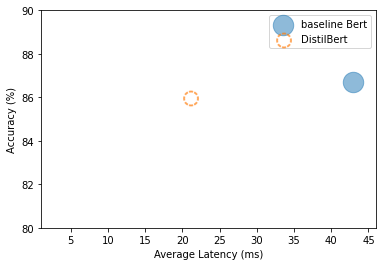

In [140]:
perf_benchmark.plot_metrics(perf_metrics, "DistilBert")

## HyperParameter Optimization

In [142]:
from optuna import trial

def hp_space(trial):
    return {
        "num_train_epochs": trial.suggest_int("num_train_epochs", 5, 10),
        "alpha": trial.suggest_float("alpha", 0,1),
        "temperature": trial.suggest_int("temperature", 2, 20),
        }

best_run = distilbert_trainer.hyperparameter_search(n_trials=20, direction="maximize", hp_space=hp_space)

print(best_run)

[I 2022-09-11 07:29:26,217] A new study created in memory with name: no-name-49770998-eee1-46c5-ad71-93fe3f5a8f76
/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 409.7368469238281, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 30.4813, 'eval_samples_per_second': 101.702, 'eval_steps_per_second': 2.132, 'epoch': 1.0}
{'loss': 585.9738, 'learning_rate': 1.606918238993711e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 127.71336364746094, 'eval_accuracy': 0.8151612903225807, 'eval_runtime': 30.0479, 'eval_samples_per_second': 103.169, 'eval_steps_per_second': 2.163, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 55.2181510925293, 'eval_accuracy': 0.8983870967741936, 'eval_runtime': 26.7488, 'eval_samples_per_second': 115.893, 'eval_steps_per_second': 2.43, 'epoch': 3.0}
{'loss': 134.2968, 'learning_rate': 1.2138364779874214e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 36.8720703125, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 26.6206, 'eval_samples_per_second': 116.451, 'eval_steps_per_second': 2.442, 'epoch': 4.0}
{'loss': 45.1987, 'learning_rate': 8.207547169811321e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 28.893110275268555, 'eval_accuracy': 0.927741935483871, 'eval_runtime': 27.0378, 'eval_samples_per_second': 114.654, 'eval_steps_per_second': 2.404, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 25.15157699584961, 'eval_accuracy': 0.932258064516129, 'eval_runtime': 26.6904, 'eval_samples_per_second': 116.147, 'eval_steps_per_second': 2.435, 'epoch': 6.0}
{'loss': 28.6735, 'learning_rate': 4.276729559748428e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 23.15143394470215, 'eval_accuracy': 0.9348387096774193, 'eval_runtime': 25.9114, 'eval_samples_per_second': 119.638, 'eval_steps_per_second': 2.509, 'epoch': 7.0}
{'loss': 23.4454, 'learning_rate': 3.459119496855346e-07, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 08:09:12,077] Trial 0 finished with value: 0.9329032258064516 and parameters: {'num_train_epochs': 8, 'alpha': 0.6222876118819244, 'temperature': 20}. Best is trial 0 with value: 0.9329032258064516.


{'eval_loss': 22.747631072998047, 'eval_accuracy': 0.9329032258064516, 'eval_runtime': 25.6247, 'eval_samples_per_second': 120.977, 'eval_steps_per_second': 2.537, 'epoch': 8.0}
{'train_runtime': 2384.2609, 'train_samples_per_second': 51.169, 'train_steps_per_second': 1.067, 'train_loss': 161.08817348840103, 'epoch': 8.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1590 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 17.08588218688965, 'eval_accuracy': 0.6638709677419354, 'eval_runtime': 25.722, 'eval_samples_per_second': 120.519, 'eval_steps_per_second': 2.527, 'epoch': 1.0}
{'loss': 23.9613, 'learning_rate': 1.371069182389937e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 6.32084321975708, 'eval_accuracy': 0.7887096774193548, 'eval_runtime': 25.5805, 'eval_samples_per_second': 121.186, 'eval_steps_per_second': 2.541, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.0382401943206787, 'eval_accuracy': 0.8648387096774194, 'eval_runtime': 25.6715, 'eval_samples_per_second': 120.756, 'eval_steps_per_second': 2.532, 'epoch': 3.0}
{'loss': 6.7057, 'learning_rate': 7.421383647798742e-06, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 2.15744948387146, 'eval_accuracy': 0.8964516129032258, 'eval_runtime': 25.0899, 'eval_samples_per_second': 123.556, 'eval_steps_per_second': 2.591, 'epoch': 4.0}
{'loss': 2.8818, 'learning_rate': 1.1320754716981133e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 08:31:55,203] Trial 1 finished with value: 0.9041935483870968 and parameters: {'num_train_epochs': 5, 'alpha': 0.283648179224557, 'temperature': 4}. Best is trial 0 with value: 0.9329032258064516.


{'eval_loss': 1.9527842998504639, 'eval_accuracy': 0.9041935483870968, 'eval_runtime': 26.2067, 'eval_samples_per_second': 118.29, 'eval_steps_per_second': 2.48, 'epoch': 5.0}
{'train_runtime': 1361.4542, 'train_samples_per_second': 56.006, 'train_steps_per_second': 1.168, 'train_loss': 10.68751485572671, 'epoch': 5.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 327.34002685546875, 'eval_accuracy': 0.6738709677419354, 'eval_runtime': 26.0987, 'eval_samples_per_second': 118.78, 'eval_steps_per_second': 2.491, 'epoch': 1.0}
{'loss': 471.2332, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 96.70613098144531, 'eval_accuracy': 0.8219354838709677, 'eval_runtime': 25.7383, 'eval_samples_per_second': 120.443, 'eval_steps_per_second': 2.525, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 41.269439697265625, 'eval_accuracy': 0.9051612903225806, 'eval_runtime': 26.2184, 'eval_samples_per_second': 118.237, 'eval_steps_per_second': 2.479, 'epoch': 3.0}
{'loss': 101.7273, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 27.358102798461914, 'eval_accuracy': 0.9174193548387096, 'eval_runtime': 25.6457, 'eval_samples_per_second': 120.878, 'eval_steps_per_second': 2.535, 'epoch': 4.0}
{'loss': 32.7561, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 21.0953369140625, 'eval_accuracy': 0.932258064516129, 'eval_runtime': 26.762, 'eval_samples_per_second': 115.836, 'eval_steps_per_second': 2.429, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 18.05329704284668, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 29.5449, 'eval_samples_per_second': 104.925, 'eval_steps_per_second': 2.2, 'epoch': 6.0}
{'loss': 20.1956, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 16.241361618041992, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 28.8791, 'eval_samples_per_second': 107.344, 'eval_steps_per_second': 2.251, 'epoch': 7.0}
{'loss': 15.8756, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 15.52964973449707, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 28.5586, 'eval_samples_per_second': 108.549, 'eval_steps_per_second': 2.276, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 14.770811080932617, 'eval_accuracy': 0.9387096774193548, 'eval_runtime': 25.7831, 'eval_samples_per_second': 120.234, 'eval_steps_per_second': 2.521, 'epoch': 9.0}
{'loss': 14.2997, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 09:20:11,135] Trial 2 finished with value: 0.9383870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.6614300866291808, 'temperature': 18}. Best is trial 2 with value: 0.9383870967741935.


{'eval_loss': 14.756326675415039, 'eval_accuracy': 0.9383870967741935, 'eval_runtime': 26.0808, 'eval_samples_per_second': 118.862, 'eval_steps_per_second': 2.492, 'epoch': 10.0}
{'train_runtime': 2893.3458, 'train_samples_per_second': 52.707, 'train_steps_per_second': 1.099, 'train_loss': 103.9290378402614, 'epoch': 10.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 16.1613826751709, 'eval_accuracy': 0.6735483870967742, 'eval_runtime': 26.9254, 'eval_samples_per_second': 115.133, 'eval_steps_per_second': 2.414, 'epoch': 1.0}
{'loss': 23.2693, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 4.773478984832764, 'eval_accuracy': 0.8216129032258065, 'eval_runtime': 26.3137, 'eval_samples_per_second': 117.809, 'eval_steps_per_second': 2.47, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 2.038999319076538, 'eval_accuracy': 0.905483870967742, 'eval_runtime': 26.939, 'eval_samples_per_second': 115.075, 'eval_steps_per_second': 2.413, 'epoch': 3.0}
{'loss': 5.0244, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.35089910030365, 'eval_accuracy': 0.9174193548387096, 'eval_runtime': 26.057, 'eval_samples_per_second': 118.97, 'eval_steps_per_second': 2.495, 'epoch': 4.0}
{'loss': 1.6185, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.0419921875, 'eval_accuracy': 0.9319354838709677, 'eval_runtime': 26.4705, 'eval_samples_per_second': 117.111, 'eval_steps_per_second': 2.456, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8910449147224426, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.3323, 'eval_samples_per_second': 117.726, 'eval_steps_per_second': 2.468, 'epoch': 6.0}
{'loss': 0.998, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8019853234291077, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 25.9198, 'eval_samples_per_second': 119.599, 'eval_steps_per_second': 2.508, 'epoch': 7.0}
{'loss': 0.7842, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7670263648033142, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 26.259, 'eval_samples_per_second': 118.055, 'eval_steps_per_second': 2.475, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.7290367484092712, 'eval_accuracy': 0.9387096774193548, 'eval_runtime': 26.8787, 'eval_samples_per_second': 115.333, 'eval_steps_per_second': 2.418, 'epoch': 9.0}
{'loss': 0.7064, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 10:06:07,513] Trial 3 finished with value: 0.9387096774193548 and parameters: {'num_train_epochs': 10, 'alpha': 0.5061930041800977, 'temperature': 4}. Best is trial 3 with value: 0.9387096774193548.


{'eval_loss': 0.7284942269325256, 'eval_accuracy': 0.9387096774193548, 'eval_runtime': 26.4123, 'eval_samples_per_second': 117.37, 'eval_steps_per_second': 2.461, 'epoch': 10.0}
{'train_runtime': 2755.101, 'train_samples_per_second': 55.352, 'train_steps_per_second': 1.154, 'train_loss': 5.132544873795419, 'epoch': 10.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 65.56271362304688, 'eval_accuracy': 0.6716129032258065, 'eval_runtime': 25.8732, 'eval_samples_per_second': 119.815, 'eval_steps_per_second': 2.512, 'epoch': 1.0}
{'loss': 93.7595, 'learning_rate': 1.606918238993711e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 20.434467315673828, 'eval_accuracy': 0.8151612903225807, 'eval_runtime': 25.868, 'eval_samples_per_second': 119.839, 'eval_steps_per_second': 2.513, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 8.83426284790039, 'eval_accuracy': 0.8980645161290323, 'eval_runtime': 26.4226, 'eval_samples_per_second': 117.324, 'eval_steps_per_second': 2.46, 'epoch': 3.0}
{'loss': 21.4854, 'learning_rate': 1.2138364779874214e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 5.897258281707764, 'eval_accuracy': 0.9145161290322581, 'eval_runtime': 26.0999, 'eval_samples_per_second': 118.774, 'eval_steps_per_second': 2.49, 'epoch': 4.0}
{'loss': 7.2277, 'learning_rate': 8.207547169811321e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 4.620263576507568, 'eval_accuracy': 0.9270967741935484, 'eval_runtime': 26.5758, 'eval_samples_per_second': 116.648, 'eval_steps_per_second': 2.446, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 4.021986484527588, 'eval_accuracy': 0.9325806451612904, 'eval_runtime': 26.3011, 'eval_samples_per_second': 117.866, 'eval_steps_per_second': 2.471, 'epoch': 6.0}
{'loss': 4.5845, 'learning_rate': 4.276729559748428e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.7031381130218506, 'eval_accuracy': 0.9341935483870968, 'eval_runtime': 26.1239, 'eval_samples_per_second': 118.665, 'eval_steps_per_second': 2.488, 'epoch': 7.0}
{'loss': 3.7489, 'learning_rate': 3.459119496855346e-07, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 10:42:46,151] Trial 4 finished with value: 0.9335483870967742 and parameters: {'num_train_epochs': 8, 'alpha': 0.7470901685855658, 'temperature': 8}. Best is trial 3 with value: 0.9387096774193548.


{'eval_loss': 3.6388418674468994, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.5806, 'eval_samples_per_second': 116.626, 'eval_steps_per_second': 2.445, 'epoch': 8.0}
{'train_runtime': 2197.334, 'train_samples_per_second': 55.522, 'train_steps_per_second': 1.158, 'train_loss': 25.772505664225644, 'epoch': 8.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 409.7368469238281, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 26.279, 'eval_samples_per_second': 117.965, 'eval_steps_per_second': 2.473, 'epoch': 1.0}
{'loss': 585.9738, 'learning_rate': 1.606918238993711e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 127.71336364746094, 'eval_accuracy': 0.8151612903225807, 'eval_runtime': 26.809, 'eval_samples_per_second': 115.633, 'eval_steps_per_second': 2.425, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 55.2181510925293, 'eval_accuracy': 0.8983870967741936, 'eval_runtime': 25.9843, 'eval_samples_per_second': 119.303, 'eval_steps_per_second': 2.502, 'epoch': 3.0}
{'loss': 134.2968, 'learning_rate': 1.2138364779874214e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 36.8720703125, 'eval_accuracy': 0.9148387096774193, 'eval_runtime': 26.0868, 'eval_samples_per_second': 118.834, 'eval_steps_per_second': 2.492, 'epoch': 4.0}
{'loss': 45.1987, 'learning_rate': 8.207547169811321e-06, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 28.893110275268555, 'eval_accuracy': 0.927741935483871, 'eval_runtime': 26.7183, 'eval_samples_per_second': 116.025, 'eval_steps_per_second': 2.433, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 11:10:28,255] Trial 5 pruned. 


{'eval_loss': 25.15157699584961, 'eval_accuracy': 0.932258064516129, 'eval_runtime': 25.9174, 'eval_samples_per_second': 119.611, 'eval_steps_per_second': 2.508, 'epoch': 6.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2226 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 11:15:07,303] Trial 6 pruned. 


{'eval_loss': 50.68577575683594, 'eval_accuracy': 0.6690322580645162, 'eval_runtime': 26.2265, 'eval_samples_per_second': 118.201, 'eval_steps_per_second': 2.478, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 11:19:52,151] Trial 7 pruned. 


{'eval_loss': 36.86907196044922, 'eval_accuracy': 0.6703225806451613, 'eval_runtime': 27.773, 'eval_samples_per_second': 111.619, 'eval_steps_per_second': 2.34, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2544 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 11:24:25,400] Trial 8 pruned. 


{'eval_loss': 230.4776153564453, 'eval_accuracy': 0.6716129032258065, 'eval_runtime': 26.1272, 'eval_samples_per_second': 118.65, 'eval_steps_per_second': 2.488, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/1908 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 11:29:00,793] Trial 9 pruned. 


{'eval_loss': 67.11671447753906, 'eval_accuracy': 0.6674193548387096, 'eval_runtime': 26.301, 'eval_samples_per_second': 117.866, 'eval_steps_per_second': 2.471, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 145.4540252685547, 'eval_accuracy': 0.6738709677419354, 'eval_runtime': 26.395, 'eval_samples_per_second': 117.446, 'eval_steps_per_second': 2.463, 'epoch': 1.0}
{'loss': 209.4262, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 42.97153091430664, 'eval_accuracy': 0.822258064516129, 'eval_runtime': 25.8774, 'eval_samples_per_second': 119.796, 'eval_steps_per_second': 2.512, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 18.352121353149414, 'eval_accuracy': 0.9048387096774193, 'eval_runtime': 25.6736, 'eval_samples_per_second': 120.747, 'eval_steps_per_second': 2.532, 'epoch': 3.0}
{'loss': 45.2262, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 12.165090560913086, 'eval_accuracy': 0.9170967741935484, 'eval_runtime': 26.1802, 'eval_samples_per_second': 118.41, 'eval_steps_per_second': 2.483, 'epoch': 4.0}
{'loss': 14.5696, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 9.379666328430176, 'eval_accuracy': 0.9319354838709677, 'eval_runtime': 25.2321, 'eval_samples_per_second': 122.859, 'eval_steps_per_second': 2.576, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 8.022161483764648, 'eval_accuracy': 0.9332258064516129, 'eval_runtime': 26.2807, 'eval_samples_per_second': 117.957, 'eval_steps_per_second': 2.473, 'epoch': 6.0}
{'loss': 8.9832, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 7.218976974487305, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 26.5248, 'eval_samples_per_second': 116.872, 'eval_steps_per_second': 2.451, 'epoch': 7.0}
{'loss': 7.0585, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 6.903942584991455, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 25.7039, 'eval_samples_per_second': 120.604, 'eval_steps_per_second': 2.529, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 12:10:15,002] Trial 10 pruned. 


{'eval_loss': 6.563264846801758, 'eval_accuracy': 0.9380645161290323, 'eval_runtime': 26.4321, 'eval_samples_per_second': 117.281, 'eval_steps_per_second': 2.459, 'epoch': 9.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 4.040698528289795, 'eval_accuracy': 0.6735483870967742, 'eval_runtime': 26.7558, 'eval_samples_per_second': 115.863, 'eval_steps_per_second': 2.429, 'epoch': 1.0}
{'loss': 5.8176, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.193907618522644, 'eval_accuracy': 0.8212903225806452, 'eval_runtime': 26.1192, 'eval_samples_per_second': 118.686, 'eval_steps_per_second': 2.489, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.5095374584197998, 'eval_accuracy': 0.905483870967742, 'eval_runtime': 26.1929, 'eval_samples_per_second': 118.353, 'eval_steps_per_second': 2.482, 'epoch': 3.0}
{'loss': 1.2561, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.3377636671066284, 'eval_accuracy': 0.9180645161290323, 'eval_runtime': 26.4557, 'eval_samples_per_second': 117.177, 'eval_steps_per_second': 2.457, 'epoch': 4.0}
{'loss': 0.4045, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.2604124844074249, 'eval_accuracy': 0.932258064516129, 'eval_runtime': 26.3588, 'eval_samples_per_second': 117.608, 'eval_steps_per_second': 2.466, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.22283005714416504, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.7658, 'eval_samples_per_second': 115.819, 'eval_steps_per_second': 2.428, 'epoch': 6.0}
{'loss': 0.2494, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.20045776665210724, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 26.5527, 'eval_samples_per_second': 116.749, 'eval_steps_per_second': 2.448, 'epoch': 7.0}
{'loss': 0.196, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.19164671003818512, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 26.4386, 'eval_samples_per_second': 117.253, 'eval_steps_per_second': 2.459, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.1823204606771469, 'eval_accuracy': 0.9387096774193548, 'eval_runtime': 27.019, 'eval_samples_per_second': 114.734, 'eval_steps_per_second': 2.406, 'epoch': 9.0}
{'loss': 0.1765, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 12:57:50,512] Trial 11 finished with value: 0.9383870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.5244837570964943, 'temperature': 2}. Best is trial 3 with value: 0.9387096774193548.


{'eval_loss': 0.18210305273532867, 'eval_accuracy': 0.9383870967741935, 'eval_runtime': 28.1708, 'eval_samples_per_second': 110.043, 'eval_steps_per_second': 2.307, 'epoch': 10.0}
{'train_runtime': 2854.1188, 'train_samples_per_second': 53.432, 'train_steps_per_second': 1.114, 'train_loss': 1.2831302234961552, 'epoch': 10.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 227.2723388671875, 'eval_accuracy': 0.6738709677419354, 'eval_runtime': 31.8681, 'eval_samples_per_second': 97.276, 'eval_steps_per_second': 2.04, 'epoch': 1.0}
{'loss': 327.2268, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 67.13215637207031, 'eval_accuracy': 0.8212903225806452, 'eval_runtime': 26.9622, 'eval_samples_per_second': 114.976, 'eval_steps_per_second': 2.411, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 28.668346405029297, 'eval_accuracy': 0.905483870967742, 'eval_runtime': 25.5451, 'eval_samples_per_second': 121.354, 'eval_steps_per_second': 2.545, 'epoch': 3.0}
{'loss': 70.6507, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 19.001802444458008, 'eval_accuracy': 0.9170967741935484, 'eval_runtime': 27.0105, 'eval_samples_per_second': 114.77, 'eval_steps_per_second': 2.406, 'epoch': 4.0}
{'loss': 22.7602, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 14.65249252319336, 'eval_accuracy': 0.9319354838709677, 'eval_runtime': 27.9193, 'eval_samples_per_second': 111.034, 'eval_steps_per_second': 2.328, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 12.534611701965332, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.2083, 'eval_samples_per_second': 118.283, 'eval_steps_per_second': 2.48, 'epoch': 6.0}
{'loss': 14.0344, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 14:02:16,390] Trial 12 pruned. 


{'eval_loss': 11.279304504394531, 'eval_accuracy': 0.9370967741935484, 'eval_runtime': 26.181, 'eval_samples_per_second': 118.406, 'eval_steps_per_second': 2.483, 'epoch': 7.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 14:07:44,501] Trial 13 pruned. 


{'eval_loss': 260.131103515625, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 29.4055, 'eval_samples_per_second': 105.423, 'eval_steps_per_second': 2.21, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 14:13:23,635] Trial 14 pruned. 


{'eval_loss': 122.95350646972656, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 27.5237, 'eval_samples_per_second': 112.63, 'eval_steps_per_second': 2.362, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 14:18:07,296] Trial 15 pruned. 


{'eval_loss': 122.95350646972656, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 26.8279, 'eval_samples_per_second': 115.551, 'eval_steps_per_second': 2.423, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 291.91229248046875, 'eval_accuracy': 0.6732258064516129, 'eval_runtime': 26.704, 'eval_samples_per_second': 116.088, 'eval_steps_per_second': 2.434, 'epoch': 1.0}
{'loss': 420.3007, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 86.21381378173828, 'eval_accuracy': 0.8216129032258065, 'eval_runtime': 25.4834, 'eval_samples_per_second': 121.648, 'eval_steps_per_second': 2.551, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 36.84004211425781, 'eval_accuracy': 0.9051612903225806, 'eval_runtime': 26.2205, 'eval_samples_per_second': 118.228, 'eval_steps_per_second': 2.479, 'epoch': 3.0}
{'loss': 90.7688, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 24.41901969909668, 'eval_accuracy': 0.9174193548387096, 'eval_runtime': 26.6674, 'eval_samples_per_second': 116.247, 'eval_steps_per_second': 2.437, 'epoch': 4.0}
{'loss': 29.2461, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 18.81529426574707, 'eval_accuracy': 0.9319354838709677, 'eval_runtime': 30.4873, 'eval_samples_per_second': 101.682, 'eval_steps_per_second': 2.132, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 16.106517791748047, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.1502, 'eval_samples_per_second': 118.546, 'eval_steps_per_second': 2.486, 'epoch': 6.0}
{'loss': 18.0296, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 14.497014045715332, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 27.1551, 'eval_samples_per_second': 114.159, 'eval_steps_per_second': 2.394, 'epoch': 7.0}
{'loss': 14.1658, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 13.857540130615234, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 28.4789, 'eval_samples_per_second': 108.852, 'eval_steps_per_second': 2.282, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 15:02:44,021] Trial 16 pruned. 


{'eval_loss': 13.173480033874512, 'eval_accuracy': 0.9380645161290323, 'eval_runtime': 29.3478, 'eval_samples_per_second': 105.63, 'eval_steps_per_second': 2.215, 'epoch': 9.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2862 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 15:07:59,436] Trial 17 pruned. 


{'eval_loss': 171.7284698486328, 'eval_accuracy': 0.6729032258064516, 'eval_runtime': 29.0981, 'eval_samples_per_second': 106.536, 'eval_steps_per_second': 2.234, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/2226 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 15:13:07,267] Trial 18 pruned. 


{'eval_loss': 4.137561798095703, 'eval_accuracy': 0.6690322580645162, 'eval_runtime': 26.7342, 'eval_samples_per_second': 115.956, 'eval_steps_per_second': 2.431, 'epoch': 1.0}


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 327.34002685546875, 'eval_accuracy': 0.6738709677419354, 'eval_runtime': 28.4228, 'eval_samples_per_second': 109.067, 'eval_steps_per_second': 2.287, 'epoch': 1.0}
{'loss': 471.2332, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 96.70613098144531, 'eval_accuracy': 0.8219354838709677, 'eval_runtime': 28.9716, 'eval_samples_per_second': 107.001, 'eval_steps_per_second': 2.244, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 41.269439697265625, 'eval_accuracy': 0.9051612903225806, 'eval_runtime': 32.4699, 'eval_samples_per_second': 95.473, 'eval_steps_per_second': 2.002, 'epoch': 3.0}
{'loss': 101.7273, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 27.358102798461914, 'eval_accuracy': 0.9174193548387096, 'eval_runtime': 26.3454, 'eval_samples_per_second': 117.668, 'eval_steps_per_second': 2.467, 'epoch': 4.0}
{'loss': 32.7561, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 21.0953369140625, 'eval_accuracy': 0.932258064516129, 'eval_runtime': 25.1037, 'eval_samples_per_second': 123.488, 'eval_steps_per_second': 2.589, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 18.05329704284668, 'eval_accuracy': 0.9335483870967742, 'eval_runtime': 26.1917, 'eval_samples_per_second': 118.358, 'eval_steps_per_second': 2.482, 'epoch': 6.0}
{'loss': 20.1956, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 16.241361618041992, 'eval_accuracy': 0.9374193548387096, 'eval_runtime': 25.7698, 'eval_samples_per_second': 120.296, 'eval_steps_per_second': 2.522, 'epoch': 7.0}
{'loss': 15.8756, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 15.52964973449707, 'eval_accuracy': 0.9364516129032258, 'eval_runtime': 25.4093, 'eval_samples_per_second': 122.003, 'eval_steps_per_second': 2.558, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 14.770811080932617, 'eval_accuracy': 0.9387096774193548, 'eval_runtime': 26.6081, 'eval_samples_per_second': 116.506, 'eval_steps_per_second': 2.443, 'epoch': 9.0}
{'loss': 14.2997, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

[I 2022-09-11 16:01:32,850] Trial 19 finished with value: 0.9383870967741935 and parameters: {'num_train_epochs': 10, 'alpha': 0.5554176692884056, 'temperature': 18}. Best is trial 3 with value: 0.9387096774193548.


{'eval_loss': 14.756326675415039, 'eval_accuracy': 0.9383870967741935, 'eval_runtime': 26.6846, 'eval_samples_per_second': 116.172, 'eval_steps_per_second': 2.436, 'epoch': 10.0}
{'train_runtime': 2904.3256, 'train_samples_per_second': 52.508, 'train_steps_per_second': 1.095, 'train_loss': 103.9290378402614, 'epoch': 10.0}
BestRun(run_id='3', objective=0.9387096774193548, hyperparameters={'num_train_epochs': 10, 'alpha': 0.5061930041800977, 'temperature': 4})


### Execute Run with best parameters

In [148]:
best_run.hyperparameters

{'num_train_epochs': 10, 'alpha': 0.5061930041800977, 'temperature': 4}

In [150]:
for k,v in best_run.hyperparameters.items():
    setattr(student_training_args, k, v)

DISTILLED_CKPT = "n08-distilbert-base-uncased-distilled-clinc"
student_training_args.output_dir = DISTILLED_CKPT

# instantiate trainer with optimal hyperparameters
distil_trainer = distillation.DistillationTrainer(
    model_init=student_init,
    teacher_model=teacher_model,
    args=student_training_args,
    train_dataset=clinc_enc["train"],
    eval_dataset=clinc_enc["validation"],
    compute_metrics=compute_metrics,
    tokenizer=student_tokenizer,
)

distil_trainer.train();

distil_trainer.save_model()

/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


  0%|          | 0/3180 [00:00<?, ?it/s]

  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 9.588530540466309, 'eval_accuracy': 0.6819354838709677, 'eval_runtime': 30.2821, 'eval_samples_per_second': 102.371, 'eval_steps_per_second': 2.146, 'epoch': 1.0}
{'loss': 13.3625, 'learning_rate': 1.685534591194969e-05, 'epoch': 1.57}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 3.1719703674316406, 'eval_accuracy': 0.8293548387096774, 'eval_runtime': 28.9356, 'eval_samples_per_second': 107.135, 'eval_steps_per_second': 2.246, 'epoch': 2.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.5561734437942505, 'eval_accuracy': 0.9051612903225806, 'eval_runtime': 25.8795, 'eval_samples_per_second': 119.786, 'eval_steps_per_second': 2.512, 'epoch': 3.0}
{'loss': 3.2106, 'learning_rate': 1.371069182389937e-05, 'epoch': 3.14}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 1.1648995876312256, 'eval_accuracy': 0.9212903225806451, 'eval_runtime': 25.1574, 'eval_samples_per_second': 123.224, 'eval_steps_per_second': 2.584, 'epoch': 4.0}
{'loss': 1.2406, 'learning_rate': 1.0566037735849058e-05, 'epoch': 4.72}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.9908452033996582, 'eval_accuracy': 0.9348387096774193, 'eval_runtime': 28.0752, 'eval_samples_per_second': 110.418, 'eval_steps_per_second': 2.315, 'epoch': 5.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.9036418199539185, 'eval_accuracy': 0.9367741935483871, 'eval_runtime': 28.8135, 'eval_samples_per_second': 107.588, 'eval_steps_per_second': 2.256, 'epoch': 6.0}
{'loss': 0.8822, 'learning_rate': 7.421383647798742e-06, 'epoch': 6.29}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8503142595291138, 'eval_accuracy': 0.9409677419354838, 'eval_runtime': 29.7615, 'eval_samples_per_second': 104.161, 'eval_steps_per_second': 2.184, 'epoch': 7.0}
{'loss': 0.7581, 'learning_rate': 4.276729559748428e-06, 'epoch': 7.86}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8329495191574097, 'eval_accuracy': 0.9390322580645162, 'eval_runtime': 30.3222, 'eval_samples_per_second': 102.235, 'eval_steps_per_second': 2.144, 'epoch': 8.0}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8109413385391235, 'eval_accuracy': 0.942258064516129, 'eval_runtime': 26.7929, 'eval_samples_per_second': 115.703, 'eval_steps_per_second': 2.426, 'epoch': 9.0}
{'loss': 0.7149, 'learning_rate': 1.1320754716981133e-06, 'epoch': 9.43}


  0%|          | 0/65 [00:00<?, ?it/s]

{'eval_loss': 0.8100083470344543, 'eval_accuracy': 0.9416129032258065, 'eval_runtime': 26.1298, 'eval_samples_per_second': 118.639, 'eval_steps_per_second': 2.488, 'epoch': 10.0}
{'train_runtime': 3032.4203, 'train_samples_per_second': 50.29, 'train_steps_per_second': 1.049, 'train_loss': 3.2104153159279494, 'epoch': 10.0}


Model Size (MB):      255.9
Avg. Latency (ms): 20.08 +/- 2.28
Model Accuracy:       86.16%


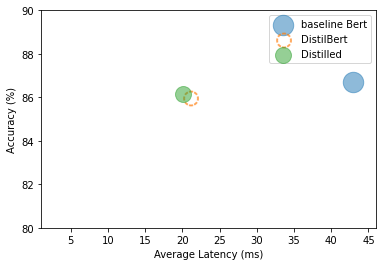

In [151]:
def pb_run_log_plot(pm: perf_benchmark.PerfMetrics, optim_type: str, model_ckpt: str) -> None:
    """run benchmark. update metrics report and save. plot metrics"""
    pipe = tfm.pipeline("text-classification", model_ckpt)

    pb = perf_benchmark.PerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type)
    pm.update(pb.run_benchmark())

    pm.to_pkl()

    perf_benchmark.plot_metrics(perf_metrics, optim_type)

pb_run_log_plot(perf_metrics, optim_type="Distilled", model_ckpt=DISTILLED_CKPT)
    

## Quantization

In [163]:
backend = "qnnpack"
qconfig = torch.quantization.get_default_qconfig(backend)  

In [165]:
from secrets import token_urlsafe
from torch.quantization import quantize_dynamic

tokenizer = tfm.AutoTokenizer.from_pretrained(DISTILLED_CKPT)
model = tfm.AutoModelForSequenceClassification.from_pretrained(DISTILLED_CKPT) #.to("cpu")

# setting up proper backend
backend = "qnnpack"
qconfig = torch.quantization.get_default_qconfig(backend)  
torch.backends.quantized.engine = backend

model_quantized = quantize_dynamic(model, qconfig_spec={torch.nn.Linear}, dtype=torch.qint8)

In [166]:
pipe = tfm.pipeline("text-classification", model=model_quantized, tokenizer=tokenizer)

pb = perf_benchmark.PerformanceBenchmark(pipe, clinc["test"], optim_type="Distillation + Quantization")
perf_metrics.update(pb.run_benchmark())

perf_metrics.to_pkl()

Model Size (MB):      132.4
Avg. Latency (ms): 16.42 +/- 0.49
Model Accuracy:       86.45%


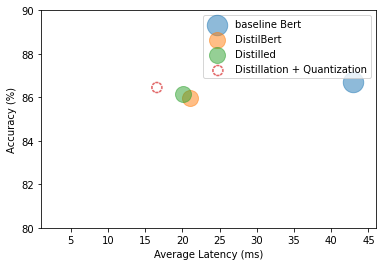

In [168]:
perf_benchmark.plot_metrics(perf_metrics, "Distillation + Quantization")

In [174]:
import pandas as pd

pd.DataFrame.from_dict(perf_metrics.metrics).round(3)

,baseline Bert,DistilBert,Distilled,Distillation + Quantization
size,418.163,255.887,255.887,132.396
latency_ms_avg,42.976,21.025,20.081,16.418
latency_ms_std,4.500,2.509,2.278,0.485
accuracy,0.867,0.860,0.862,0.865


The Quantized Model saves about ~20% on latency here, but 
## Optimizing Inference with ONNX and ONNX Runtime
### Save model in ONNX format

In [181]:
from pathlib import Path
from psutil import cpu_count
import os

os.environ["OMP_NUM_THREADS"] = f"{cpu_count()}"
os.environ["OMP_WAIT_POLICY"] = "ACTIVE"

onnx_model_path = Path("n08_onnx/model.onnx")

tfm.convert_graph_to_onnx.convert(
    framework="pt",
    model=DISTILLED_CKPT,
    tokenizer=tokenizer,
    output=onnx_model_path,
    opset=12,
    pipeline_name="text-classification",
)


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/convert_graph_to_onnx.py:378: FutureWarning: The `transformers.convert_graph_to_onnx` package is deprecated and will be removed in version 5 of Transformers
  warnings.warn(


ONNX opset version set to: 12
Loading pipeline (model: distilbert-base-uncased-distilled-clinc, tokenizer: PreTrainedTokenizerFast(name_or_path='distilbert-base-uncased-distilled-clinc', vocab_size=30522, model_max_len=512, is_fast=True, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}))
Creating folder n08_onnx
Using framework PyTorch: 1.13.0.dev20220606
Found input input_ids with shape: {0: 'batch', 1: 'sequence'}
Found input attention_mask with shape: {0: 'batch', 1: 'sequence'}
Found output output_0 with shape: {0: 'batch'}
Ensuring inputs are in correct order
head_mask is not present in the generated input list.
Generated inputs order: ['input_ids', 'attention_mask']


/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/transformers/models/distilbert/modeling_distilbert.py:214: TracerWarning: torch.tensor results are registered as constants in the trace. You can safely ignore this warning if you use this function to create tensors out of constant variables that would be the same every time you call this function. In any other case, this might cause the trace to be incorrect.
  scores = scores.masked_fill(mask, torch.tensor(-float("inf")))  # (bs, n_heads, q_length, k_length)
/opt/homebrew/Caskroom/miniforge/base/envs/transformers_test/lib/python3.10/site-packages/torch/onnx/symbolic_helper.py:1145: UserWarning: ONNX export mode is set to False, but operator 'dropout' is set to train=False. Exporting with train=False.
  warnings.warn(


### load model for ONNX RunTime

In [183]:
from src.n08 import onnx

# load model with ONNX
onnx_model = onnx.create_model_for_provider(onnx_model_path)

#### evaluate 

In [198]:
inputs = clinc_enc["test"][:1]
label = inputs.pop("labels")[0]
logits_onnx = onnx_model.run(None, inputs)[0]

preds = np.argmax(logits_onnx)
f"prediction: {preds}, true label: {label}"

'prediction: 61, true label: 61'

In [206]:
# create pipeline
pipe = onnx.OnnxPipeline(model=onnx_model, tokenizer=tokenizer, id2labels=intents.int2str)

pipe(query)

[{'label': 'book_flight', 'score': 0.27645037}]

In [211]:
optim_type = "Distillation + ORT"
pb = perf_benchmark.OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type=optim_type, model_path=onnx_model_path)
perf_metrics.update(pb.run_benchmark())

Model Size (MB):      255.0
Avg. Latency (ms): 17.30 +/- 0.46
Model Accuracy:       86.16%


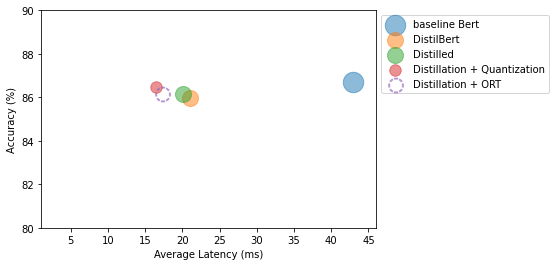

In [215]:
perf_benchmark.plot_metrics(perf_metrics, optim_type)

In [217]:
from onnxruntime.quantization import quantize_dynamic, QuantType
model_input = "n08_onnx/model.onnx"
model_output = "n08_onnx/model.quant.onnx"
quantize_dynamic(model_input, model_output, weight_type=QuantType.QInt8)



Ignore MatMul due to non constant B: /[MatMul_121]
Ignore MatMul due to non constant B: /[MatMul_134]
Ignore MatMul due to non constant B: /[MatMul_203]
Ignore MatMul due to non constant B: /[MatMul_216]
Ignore MatMul due to non constant B: /[MatMul_285]
Ignore MatMul due to non constant B: /[MatMul_298]
Ignore MatMul due to non constant B: /[MatMul_367]
Ignore MatMul due to non constant B: /[MatMul_380]
Ignore MatMul due to non constant B: /[MatMul_449]
Ignore MatMul due to non constant B: /[MatMul_462]
Ignore MatMul due to non constant B: /[MatMul_531]
Ignore MatMul due to non constant B: /[MatMul_544]


In [221]:
onnx_quantized_model = onnx.create_model_for_provider(model_output)
pipe = onnx.OnnxPipeline(onnx_quantized_model, tokenizer=tokenizer, id2labels=intents.int2str)
optim_type = "Distillation + ORT + Quantization"
pb = perf_benchmark.OnnxPerformanceBenchmark(pipe, clinc["test"], optim_type, model_path=model_output)

perf_metrics.update(pb.run_benchmark())


Model Size (MB):       64.0
Avg. Latency (ms): 11.55 +/- 0.57
Model Accuracy:       86.69%


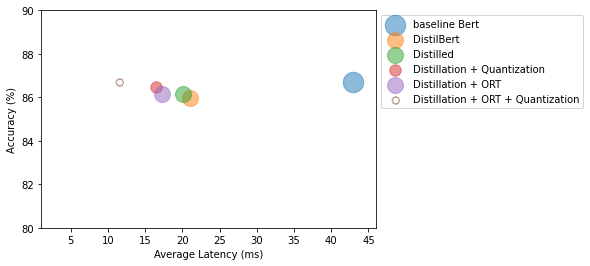

In [222]:
perf_benchmark.plot_metrics(perf_metrics, optim_type)

In [229]:
sizes = pd.DataFrame(perf_metrics.metrics).loc["size",:]
sizes.max() / sizes.min()

6.533796027302742

In [233]:
perf_metrics??

Type:        PerfMetrics
String form:
baseline Bert            {'size': 418.1629457473755, 'latency_ms_avg': 42.975668828585185, 'latency_ms_std': 4.500188071834349, 'accuracy': 0.8672727272727273}
DistilBert               {'size': 255.887375831604, 'latency_ms_avg': 21.02458419976756, 'latency_ms_std': 2.509321777292666, 'accuracy': 0.8598181818181818}
Distilled                {'size': 255.887375831604, 'latency_ms_avg': 20.080723389983177, 'latency_ms_std': 2.277982428745364, 'accuracy': 0.8616363636363636}
Distillation + Quantization{'size': 132.3961420059204, 'latency_ms_avg': 16.418234558659606, 'latency_ms_std': 0.48508236204886523, 'accuracy': 0.8645454545454545}
Distillation + ORT       {'size': 255, 'latency_ms_avg': 17.296920056978706, 'latency_ms_std': 0.46197105927182414, 'accuracy': 0.8616363636363636}
Distillation + ORT + Quantization{'size': 64, 'latency_ms_avg': 11.551636266813148, 'latency_ms_std': 0.5704890659161305, 'accuracy': 0.866909090909091}
File:        ~/proje

In [235]:
PerfMetrics??

Init signature: PerfMetrics()
Docstring:      <no docstring>
Type:           type
Subclasses:     
